In [1]:
#Import des packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [3]:
class SmallVGGNet:
    def classifier(width, height, depth, classes):
        # Initialiser le modèle ainsi que les dimensions d'entrée
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
        # Première couche de convolution
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # Deuxième couche de convolution
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # Troisième couche de convolution
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # Couche fully connected
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # Classificateur softmax pour plus de deux classes
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        return model

In [4]:
# Chemin d'accès aux images
my_path ='./dataset/'

In [5]:
def load_data(data_dir, new_size=None):
    if not new_size is None:
        img_rows, img_cols = new_size
    labels = []
    data = []
    for label in  os.listdir(data_dir):
        for img_path in os.listdir(data_dir+label+'/'):
            img = cv2.imread(data_dir+label+'/'+img_path)
            img=cv2.resize(img, (img_rows, img_cols))
            lab = img_path.split('_')[0]
            data.append(img)
            labels.append(lab)
    return data, labels

In [6]:
# Charger les images depuis le chemin indiqué
data, labels = load_data(my_path, (64, 64))

In [7]:
# Mettre les intensités brutes de chaque pixel dans [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [8]:
# Séparer notre data en trainSet et testSet
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [9]:
# Convertir les labels d'entiers en vecteurs par exemple cats = [1 0 0], dogs = [0 1 0], panda = [0 0 1] 
labelBin = LabelBinarizer()
trainY = labelBin.fit_transform(trainY)
testY = labelBin.transform(testY)

In [10]:
# Construire le générateur d'image pour faire la data augmentation
aug = ImageDataGenerator(rotation_range=30, 
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest"
                        )

In [13]:
# Initialisation du modèle
model = SmallVGGNet.classifier(width=64, height=64, depth=3, classes=len(labelBin.classes_))

In [14]:
# Initialiser notre taux d'apprentissage de départ et les époques d'entrainemeent
INIT_LR = 0.01
EPOCHS = 80
BATCH_SIZE = 32

In [15]:
# Initialiser le modèle et l'optimiseur 
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model_history = model.fit(x=aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
                          validation_data=(testX, testY),
                          steps_per_epoch=len(trainX) // BATCH_SIZE,
                          epochs=EPOCHS)

Epoch 1/80
70/70 [==============================] - 32s 462ms/step - loss: 1.3891 - accuracy: 0.5230 - val_loss: 1.6781 - val_accuracy: 0.3507
Epoch 2/80
70/70 [==============================] - 33s 473ms/step - loss: 1.0646 - accuracy: 0.5834 - val_loss: 1.7907 - val_accuracy: 0.3493
Epoch 3/80
70/70 [==============================] - 33s 467ms/step - loss: 0.8896 - accuracy: 0.6204 - val_loss: 2.0980 - val_accuracy: 0.3480
Epoch 4/80
70/70 [==============================] - 33s 472ms/step - loss: 0.8218 - accuracy: 0.6307 - val_loss: 1.8222 - val_accuracy: 0.3467
Epoch 5/80
70/70 [==============================] - 33s 472ms/step - loss: 0.7992 - accuracy: 0.6452 - val_loss: 1.5632 - val_accuracy: 0.3493
Epoch 6/80
70/70 [==============================] - 33s 473ms/step - loss: 0.7514 - accuracy: 0.6551 - val_loss: 1.3269 - val_accuracy: 0.4013
Epoch 7/80
70/70 [==============================] - 32s 464ms/step - loss: 0.7309 - accuracy: 0.6420 - val_loss: 1.2424 - val_accuracy: 0.4493

Epoch 58/80
70/70 [==============================] - 33s 467ms/step - loss: 0.4533 - accuracy: 0.7962 - val_loss: 0.5441 - val_accuracy: 0.7720
Epoch 59/80
70/70 [==============================] - 33s 475ms/step - loss: 0.4549 - accuracy: 0.7976 - val_loss: 0.5502 - val_accuracy: 0.7787
Epoch 60/80
70/70 [==============================] - 33s 472ms/step - loss: 0.4934 - accuracy: 0.7764 - val_loss: 0.7708 - val_accuracy: 0.6707
Epoch 61/80
70/70 [==============================] - 33s 470ms/step - loss: 0.4443 - accuracy: 0.7944 - val_loss: 0.7766 - val_accuracy: 0.6933
Epoch 62/80
70/70 [==============================] - 34s 492ms/step - loss: 0.4448 - accuracy: 0.7922 - val_loss: 0.5432 - val_accuracy: 0.7680
Epoch 63/80
70/70 [==============================] - 34s 489ms/step - loss: 0.4286 - accuracy: 0.7960 - val_loss: 1.2247 - val_accuracy: 0.5893
Epoch 64/80
70/70 [==============================] - 33s 478ms/step - loss: 0.4335 - accuracy: 0.8048 - val_loss: 0.6681 - val_accuracy:

In [16]:
predictions = model.predict(x=testX, batch_size=32)

In [44]:
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelBin.classes_)
     )

              precision    recall  f1-score   support

        cats       0.67      0.86      0.75       262
        dogs       0.74      0.58      0.65       249
       panda       0.97      0.90      0.93       239

    accuracy                           0.78       750
   macro avg       0.80      0.78      0.78       750
weighted avg       0.79      0.78      0.78       750



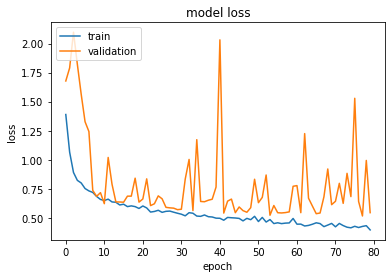

In [17]:
# Resumé de l'historique du modèle pour les pertes
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

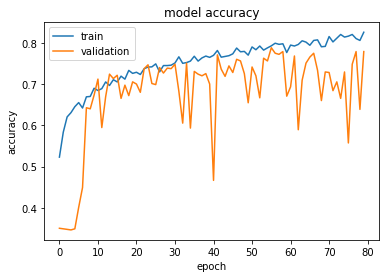

In [20]:
# Resumé de l'historique du modèle pour les performances
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
# Sauvegarder notre modèle et les labels bineariser sur le disque
model.save('./output/CNN_classifier', save_format="h5")
f = open('./output/CNN_label.pickle', "wb")
f.write(pickle.dumps(labelBin))
f.close()

In [23]:
# Charger le modèle et le convertisseur binaire des labels
model = load_model('./output/CNN_classifier')
labelBin = pickle.loads(open('./output/CNN_label.pickle', "rb").read())

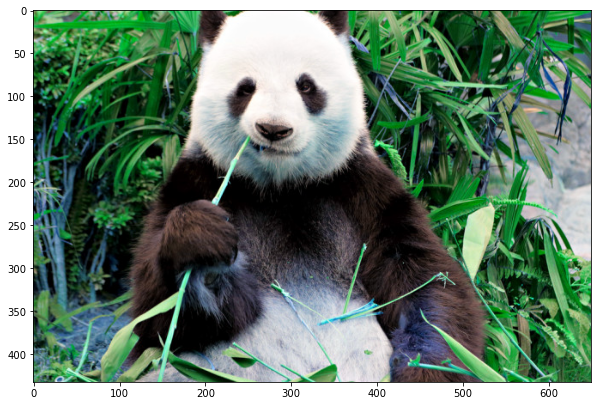

In [38]:
# Charger une image et la classifier
image = cv2.imread('./test/panda3.jpg')
output = image.copy()
plt.figure(figsize = (10,10))
plt.imshow(image)
plt.show()

In [39]:
image = cv2.resize(image, (64, 64))
image = image.astype("float") / 255.0
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

In [40]:
# Faire la prédiction
predicts = model.predict(image)

In [41]:
# Trouver la classe 
i = predicts.argmax(axis=1)[0]
label = labelBin.classes_[i]

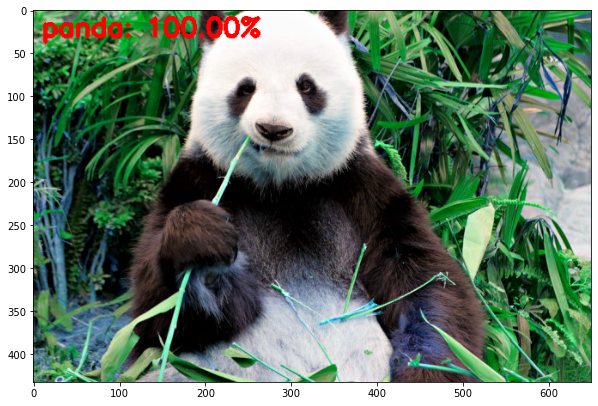

In [42]:
# Représenter l'image et sa classe prédite
text = "{}: {:.2f}%".format(label, predicts[0][i] * 100)
cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

plt.figure(figsize = (10,10))
plt.imshow(output)
plt.show()